In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import seaborn as sns
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import genfromtxt
from mpc.dynamics import AffineDynamics

%matplotlib inline
from controller_utils import sample_initial_signal, episode_loss
from controllers import DDeePC
plt.rcParams["figure.figsize"] = (15,5)
sns.set_theme()


In [2]:
ud = genfromtxt('recht_ud.csv', delimiter=',')
yd = genfromtxt('recht_yd.csv', delimiter=',')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 3 # n = number of states
m = 3 # m = number of inputs
p = 3 # p = number of output
q = m+p # q = number of i/o variables
Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1    
noise_std = 0.1              
A = torch.Tensor([[1.01, 0.01, 0.00], # A - State-space matrix
                  [0.01, 1.01, 0.01], 
                  [0.00, 0.01, 1.01]])
dx = AffineDynamics(A=A, B=torch.eye(3)).to(device)
yd += np.random.rand(T,p)*noise_std
u_ini = ud[:Tini,:].reshape((Tini*m,))
y_ini = yd[:Tini,:].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([10,10,10]))
u_constraints = np.kron(np.ones(Tf), np.array([5,5,5]))
q = torch.ones(3)*50
r = torch.ones(3)*2
lam_y = torch.Tensor([20])

## Training 

In [3]:
q = torch.ones(3)*50
r = torch.ones(3)*2
lam_y = torch.Tensor([20])
epochs = 80
batches = [8, 16, 32, 64]
losses = np.zeros((len(batches), epochs))
regularizers = np.zeros((len(batches), epochs))

for k, n_batch in enumerate(batches):

    controller = DDeePC(
        ud=ud, yd=yd, N=Tf, Tini=Tini, T=T, p=3, m=3, n_batch=n_batch,
        y_constraints=y_constraints, u_constraints=u_constraints, device=device,
        stochastic=True, linear=True, q=q, r=r
    ).to(device)

    opt = optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-3,1e2))
    print(f'Starting batch size : {n_batch}')
    pbar = tqdm(range(epochs), ncols=150)
    criterion = torch.nn.HuberLoss()
    I, PI = controller.get_PI()
    
    for i, count in enumerate(pbar):
        
        # Get random step response
        ref = torch.Tensor(np.random.uniform(size=(n_batch,p), low=-10.0, high=10.0))
        target_ref = torch.kron(torch.ones(T), ref)
        ref = torch.kron(torch.ones(Tf), ref).to(device)
        ref = torch.zeros(Tf*p).to(device)
        
        # Get random initial condition from data
        u_ini, y_ini = sample_initial_signal(Tini=Tini, m=m, p=p, batch=n_batch, ud=ud, yd=yd)
        u_ini, y_ini = u_ini.to(device), y_ini.to(device)
        uT, yT = u_ini, y_ini

        G, E, Y, U = torch.Tensor(), torch.Tensor(), torch.Tensor(), torch.Tensor()

        for j in range(25):
            # Get optimal action from controller, take MSE of trajectory and reference signal
            noise = torch.randn(y_ini.shape).to(device)*noise_std
            g, u_pred, y_pred, sig_y = controller(ref=ref, u_ini=u_ini, y_ini=y_ini)
            G, E = torch.cat((G, g.unsqueeze(1)), axis=1), torch.cat((E, sig_y.unsqueeze(1)), axis=1) 
            action = u_pred[:,:m]
            U = torch.cat((U, action.unsqueeze(1)), axis=1)
            obs = dx(action, y_ini[:,-p:])
            Y = torch.cat((Y, obs.unsqueeze(1)), axis=1)
            uT = torch.cat((uT, action), 1)
            yT = torch.cat((yT, obs), 1)
            y_ini, u_ini = yT[:,-p*Tini:], uT[:,-m*Tini:]

        # loss = criterion(input=yT[:,p*Tini:], target=target_ref)
        loss = episode_loss(Y=Y, G=G, U=U, E=E, controller=controller, PI=(I-PI))
        losses[k,i] = loss.item()
        opt.zero_grad()
        loss.backward(retain_graph=True)
        opt.step()
        regularizers[k,i] = controller.lam_y.data.item()
        pbar.set_description(f'Loss = {loss.item():.4f}, lam_y = {controller.lam_y.data.item():.3f}, q = {controller.q.data}, r = {controller.r.data}')

Starting batch size : 8


  0%|                                                                                                                          | 0/80 [00:00<?, ?it/s]/Users/michaelcummins/differentiable-deepc/src/controller_utils.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  Ct += (Y[i,j,:].T @ Q @ Y[i,j,:] + U[i,j,:].T @ R @ U[i,j,:]).reshape(1)
Loss = 53.9044, lam_y = 35.537, q = tensor([50., 50., 50.]), r = tensor([2., 2., 2.]): 100%|██████████████████████████| 80/80 [05:09<00:00,  3.87s/it]


Starting batch size : 16


Loss = 246.6855, lam_y = 32.979, q = tensor([50., 50., 50.]), r = tensor([2., 2., 2.]): 100%|█████████████████████████| 80/80 [10:45<00:00,  8.07s/it]


Starting batch size : 32


Loss = 400.5473, lam_y = 32.010, q = tensor([50., 50., 50.]), r = tensor([2., 2., 2.]): 100%|█████████████████████████| 80/80 [22:45<00:00, 17.07s/it]


Starting batch size : 64


Loss = 314.4945, lam_y = 33.855, q = tensor([50., 50., 50.]), r = tensor([2., 2., 2.]): 100%|█████████████████████████| 80/80 [54:45<00:00, 41.07s/it]


## Results

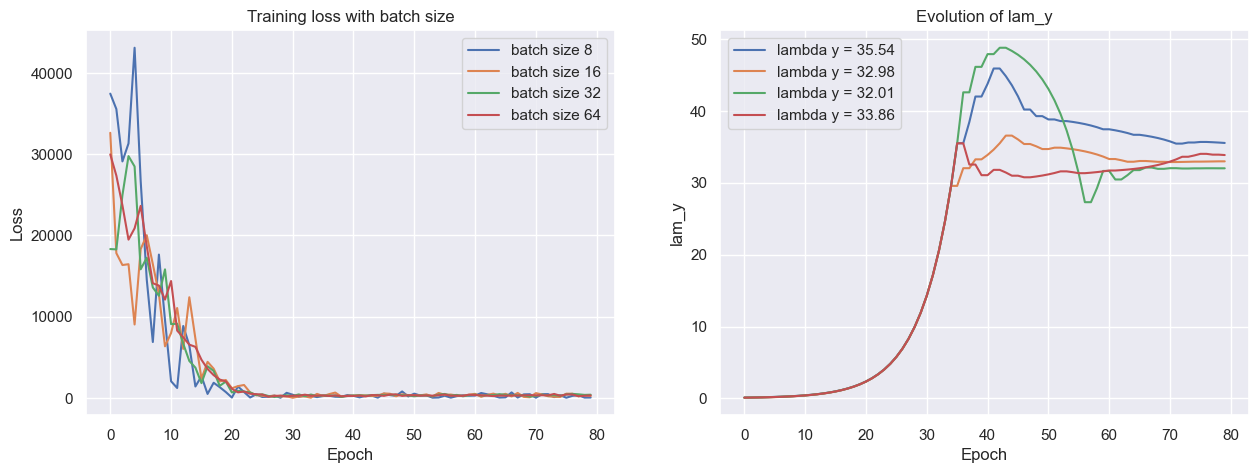

In [13]:
plt.subplot(1,2,1)
for i in range(len(batches)):
    plt.plot(range(len(losses[i,:])), losses[i,:], label=f'batch size {batches[i]}')
plt.grid('on')
plt.title(f'Training loss with batch size')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
for i in range(len(batches)):
    plt.plot(range(len(regularizers[i,:])), regularizers[i,:], label=f'lambda y = {regularizers[i, -1]:.2f}')
plt.grid('on')
plt.title(f'Evolution of lam_y')
plt.xlabel('Epoch')
plt.ylabel('lam_y')
plt.legend()
plt.show()

In [139]:
from time import time
recht_G = torch.randn((3*16*10, 7, 7), device='mps') + torch.randn((3*16*10, 7, 7), device='mps')
recht_t = time()
recht_G_inv = recht_G.inverse()
recht_t = time() - recht_t
cart_G = torch.randn((3*16*25, 70-4-25+1, 70-4-25+1), device='mps') + torch.randn((3*16*25, 70-4-25+1, 70-4-25+1), device='mps')
cart_t = time()
cart_G_inv = cart_G.inverse()
cart_t = time() - cart_t
print(f'Time for cart : {cart_t:.4f}, Recht : {recht_t:.4f}')

Time for cart : 0.0260, Recht : 0.0023
